# チームF　予測モデル最新版

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ライブラリのインポート
import lightgbm as lgb
import optuna.integration.lightgbm as lgb2
import xgboost as xgb
# import optuna
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import jpholiday
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline

/home/student16/.local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# 必要なデータの読み込み
org_df = pd.read_csv("/mnt/aibstorageshare2/share/teamF/public/data/mainbranch_delivery.csv", index_col="date", parse_dates=True)

In [4]:
temp_df = org_df.copy()
temp_df = temp_df.loc[(temp_df.index >= datetime(2020,9,1))&(temp_df.index <= datetime(2020,10,31))].copy()
temp_df.index = temp_df.index.map(lambda x: x + timedelta(days=365))
temp_df['delivery'] = 1000000000 #はじかれないようにする

In [5]:
df = pd.concat([org_df,temp_df])

## データの加工

In [6]:
# 配達量が小さいブランチ（20,22,26,44,59）を除く
df = df[df.branch_id != 20]
df = df[df.branch_id != 22]
df = df[df.branch_id != 26]
df = df[df.branch_id != 44]
df = df[df.branch_id != 59]
df = df[df.delivery >= 1000]

In [7]:

# 配達量が小さくないブランチでデータ数が足りていないもの(60)
loss = df[(df['branch_id'] == 57) & (df.index < datetime(2020,4,1))].copy()
loss['branch_id'] = 60
loss.head()
df = pd.concat([df,loss])


In [8]:
# 年、月、日、曜日、祝日の列を追加
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['is_holiday'] = df.index.map(jpholiday.is_holiday).astype(int)

In [9]:
#ブランチごとの曜日平均を導入

for j in range(1,95):
    mean_values = []
    temp_df = df.loc[df.index <= datetime(2021,8,31)].copy()
    df_1=temp_df[temp_df["branch_id"] == j].copy()
    for i in range(7):
        mean_value = df_1[df_1['weekday']==i]['delivery'].mean()
        mean_values.append(mean_value)

    df.loc[(df['weekday']==0) & (df['branch_id']==j),'mean_by_weekday'] = mean_values[0]
    df.loc[(df['weekday']==1) & (df['branch_id']==j),'mean_by_weekday'] = mean_values[1]
    df.loc[(df['weekday']==2) & (df['branch_id']==j),'mean_by_weekday'] = mean_values[2]
    df.loc[(df['weekday']==3) & (df['branch_id']==j),'mean_by_weekday'] = mean_values[3]
    df.loc[(df['weekday']==4) & (df['branch_id']==j),'mean_by_weekday'] = mean_values[4]
    df.loc[(df['weekday']==5) & (df['branch_id']==j),'mean_by_weekday'] = mean_values[5]
    df.loc[(df['weekday']==6) & (df['branch_id']==j),'mean_by_weekday'] = mean_values[6]

In [10]:
#ブランチごとの曜日標準偏差を導入

df.loc[:,'std_by_weekday'] = 0
for j in range(1,95):
    mean_values = []
    temp_df = df.loc[df.index <= datetime(2021,8,31)].copy()
    df_1=temp_df[temp_df["branch_id"] == j]
    for i in range(7):
        mean_value = df_1[df_1['weekday']==i]['delivery'].std()
        mean_values.append(mean_value)
        df_1.loc[df_1['weekday']==i ,'std_by_weekday'] = mean_value

    mean = (mean_values[1]+mean_values[2]+mean_values[3]+mean_values[4])/4


    df.loc[(df['weekday']==0) & (df['branch_id']==j),'std_by_weekday'] = mean_values[0]
    df.loc[(df['weekday']==1) & (df['branch_id']==j),'std_by_weekday'] = mean_values[1]
    df.loc[(df['weekday']==2) & (df['branch_id']==j),'std_by_weekday'] = mean_values[2]
    df.loc[(df['weekday']==3) & (df['branch_id']==j),'std_by_weekday'] = mean_values[3]
    df.loc[(df['weekday']==4) & (df['branch_id']==j),'std_by_weekday'] = mean_values[4]

    df.loc[(df['weekday']==5) & (df['branch_id']==j),'std_by_weekday'] = mean_values[5]
    df.loc[(df['weekday']==6) & (df['branch_id']==j),'std_by_weekday'] = mean_values[6]

/tmp/ipykernel_32497/722985409.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.loc[df_1['weekday']==i ,'std_by_weekday'] = mean_value


In [11]:
#ブランチごとの日別平均を導入

df.loc[:,'mean_by_day'] = 0
for j in range(1,95):
    mean_values = []
    temp_df = df.loc[df.index <= datetime(2021,8,31)].copy()
    df_1=temp_df[temp_df["branch_id"] == j]
    for i in range(1,32):
        mean_value = df_1[df_1['day']==i]['delivery'].mean()
        mean_values.append(mean_value)
        df_1.loc[df_1['day']==i ,'mean_by_day'] = mean_value

    df.loc[(df['day']==1) & (df['branch_id']==j),'mean_by_day'] = mean_values[0]
    df.loc[(df['day']==2) & (df['branch_id']==j),'mean_by_day'] = mean_values[1]
    df.loc[(df['day']==3) & (df['branch_id']==j),'mean_by_day'] = mean_values[2]
    df.loc[(df['day']==4) & (df['branch_id']==j),'mean_by_day'] = mean_values[3]
    df.loc[(df['day']==5) & (df['branch_id']==j),'mean_by_day'] = mean_values[4]
    df.loc[(df['day']==6) & (df['branch_id']==j),'mean_by_day'] = mean_values[5]
    df.loc[(df['day']==7) & (df['branch_id']==j),'mean_by_day'] = mean_values[6]
    df.loc[(df['day']==8) & (df['branch_id']==j),'mean_by_day'] = mean_values[7]
    df.loc[(df['day']==9) & (df['branch_id']==j),'mean_by_day'] = mean_values[8]
    df.loc[(df['day']==10) & (df['branch_id']==j),'mean_by_day'] = mean_values[9]
    df.loc[(df['day']==11) & (df['branch_id']==j),'mean_by_day'] = mean_values[10]
    df.loc[(df['day']==12) & (df['branch_id']==j),'mean_by_day'] = mean_values[11]
    df.loc[(df['day']==13) & (df['branch_id']==j),'mean_by_day'] = mean_values[12]
    df.loc[(df['day']==14) & (df['branch_id']==j),'mean_by_day'] = mean_values[13]
    df.loc[(df['day']==15) & (df['branch_id']==j),'mean_by_day'] = mean_values[14]
    df.loc[(df['day']==16) & (df['branch_id']==j),'mean_by_day'] = mean_values[15]
    df.loc[(df['day']==17) & (df['branch_id']==j),'mean_by_day'] = mean_values[16]
    df.loc[(df['day']==18) & (df['branch_id']==j),'mean_by_day'] = mean_values[17]
    df.loc[(df['day']==19) & (df['branch_id']==j),'mean_by_day'] = mean_values[18]
    df.loc[(df['day']==20) & (df['branch_id']==j),'mean_by_day'] = mean_values[19]
    df.loc[(df['day']==21) & (df['branch_id']==j),'mean_by_day'] = mean_values[20]
    df.loc[(df['day']==22) & (df['branch_id']==j),'mean_by_day'] = mean_values[21]
    df.loc[(df['day']==23) & (df['branch_id']==j),'mean_by_day'] = mean_values[22]
    df.loc[(df['day']==24) & (df['branch_id']==j),'mean_by_day'] = mean_values[23]
    df.loc[(df['day']==25) & (df['branch_id']==j),'mean_by_day'] = mean_values[24]
    df.loc[(df['day']==26) & (df['branch_id']==j),'mean_by_day'] = mean_values[25]
    df.loc[(df['day']==27) & (df['branch_id']==j),'mean_by_day'] = mean_values[26]
    df.loc[(df['day']==28) & (df['branch_id']==j),'mean_by_day'] = mean_values[27]
    df.loc[(df['day']==29) & (df['branch_id']==j),'mean_by_day'] = mean_values[28]
    df.loc[(df['day']==30) & (df['branch_id']==j),'mean_by_day'] = mean_values[29]
    df.loc[(df['day']==31) & (df['branch_id']==j),'mean_by_day'] = mean_values[30]

/tmp/ipykernel_32497/1631147418.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.loc[df_1['day']==i ,'mean_by_day'] = mean_value


In [12]:
#ブランチごとの日別標準偏差を導入

df.loc[:,'std_by_day'] = 0
for j in range(1,95):
    std_values = []
    temp_df = df.loc[df.index <= datetime(2021,8,31)].copy()
    df_1=temp_df[temp_df["branch_id"] == j]
    for i in range(1,32):
        std_value = df_1[df_1['day']==i]['delivery'].std()
        std_values.append(std_value)
        df_1.loc[df_1['day']==i ,'std_by_day'] = std_value

    df.loc[(df['day']==1) & (df['branch_id']==j),'std_by_day'] = std_values[0]
    df.loc[(df['day']==2) & (df['branch_id']==j),'std_by_day'] = std_values[1]
    df.loc[(df['day']==3) & (df['branch_id']==j),'std_by_day'] = std_values[2]
    df.loc[(df['day']==4) & (df['branch_id']==j),'std_by_day'] = std_values[3]
    df.loc[(df['day']==5) & (df['branch_id']==j),'std_by_day'] = std_values[4]
    df.loc[(df['day']==6) & (df['branch_id']==j),'std_by_day'] = std_values[5]
    df.loc[(df['day']==7) & (df['branch_id']==j),'std_by_day'] = std_values[6]
    df.loc[(df['day']==8) & (df['branch_id']==j),'std_by_day'] = std_values[7]
    df.loc[(df['day']==9) & (df['branch_id']==j),'std_by_day'] = std_values[8]
    df.loc[(df['day']==10) & (df['branch_id']==j),'std_by_day'] = std_values[9]
    df.loc[(df['day']==11) & (df['branch_id']==j),'std_by_day'] = std_values[10]
    df.loc[(df['day']==12) & (df['branch_id']==j),'std_by_day'] = std_values[11]
    df.loc[(df['day']==13) & (df['branch_id']==j),'std_by_day'] = std_values[12]
    df.loc[(df['day']==14) & (df['branch_id']==j),'std_by_day'] = std_values[13]
    df.loc[(df['day']==15) & (df['branch_id']==j),'std_by_day'] = std_values[14]
    df.loc[(df['day']==16) & (df['branch_id']==j),'std_by_day'] = std_values[15]
    df.loc[(df['day']==17) & (df['branch_id']==j),'std_by_day'] = std_values[16]
    df.loc[(df['day']==18) & (df['branch_id']==j),'std_by_day'] = std_values[17]
    df.loc[(df['day']==19) & (df['branch_id']==j),'std_by_day'] = std_values[18]
    df.loc[(df['day']==20) & (df['branch_id']==j),'std_by_day'] = std_values[19]
    df.loc[(df['day']==21) & (df['branch_id']==j),'std_by_day'] = std_values[20]
    df.loc[(df['day']==22) & (df['branch_id']==j),'std_by_day'] = std_values[21]
    df.loc[(df['day']==23) & (df['branch_id']==j),'std_by_day'] = std_values[22]
    df.loc[(df['day']==24) & (df['branch_id']==j),'std_by_day'] = std_values[23]
    df.loc[(df['day']==25) & (df['branch_id']==j),'std_by_day'] = std_values[24]
    df.loc[(df['day']==26) & (df['branch_id']==j),'std_by_day'] = std_values[25]
    df.loc[(df['day']==27) & (df['branch_id']==j),'std_by_day'] = std_values[26]
    df.loc[(df['day']==28) & (df['branch_id']==j),'std_by_day'] = std_values[27]
    df.loc[(df['day']==29) & (df['branch_id']==j),'std_by_day'] = std_values[28]
    df.loc[(df['day']==30) & (df['branch_id']==j),'std_by_day'] = std_values[29]
    df.loc[(df['day']==31) & (df['branch_id']==j),'std_by_day'] = std_values[30]

/tmp/ipykernel_32497/852525868.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.loc[df_1['day']==i ,'std_by_day'] = std_value


In [13]:
#ブランチごとの月平均を導入

df.loc[:,'mean_by_month'] = 0
for j in range(1,95):
    mean_values = []
    temp_df = df.loc[df.index <= datetime(2021,8,31)].copy()
    df_1=temp_df[temp_df["branch_id"] == j]
    for i in range(1,13):
        mean_value = df_1[df_1['month']==i]['delivery'].mean()
        mean_values.append(mean_value)
        df_1.loc[df_1['month']==i ,'mean_by_month'] = mean_value

    df.loc[(df['month']==1) & (df['branch_id']==j),'mean_by_month'] = mean_values[0]
    df.loc[(df['month']==2) & (df['branch_id']==j),'mean_by_month'] = mean_values[1]
    df.loc[(df['month']==3) & (df['branch_id']==j),'mean_by_month'] = mean_values[2]
    df.loc[(df['month']==4) & (df['branch_id']==j),'mean_by_month'] = mean_values[3]
    df.loc[(df['month']==5) & (df['branch_id']==j),'mean_by_month'] = mean_values[4]
    df.loc[(df['month']==6) & (df['branch_id']==j),'mean_by_month'] = mean_values[5]
    df.loc[(df['month']==7) & (df['branch_id']==j) ,'mean_by_month'] = mean_values[6]
    df.loc[(df['month']==8) & (df['branch_id']==j),'mean_by_month'] = mean_values[7]
    df.loc[(df['month']==9) & (df['branch_id']==j),'mean_by_month'] = mean_values[8]
    df.loc[(df['month']==10) & (df['branch_id']==j),'mean_by_month'] = mean_values[9]
    df.loc[(df['month']==11) & (df['branch_id']==j),'mean_by_month'] = mean_values[10]
    df.loc[(df['month']==12) & (df['branch_id']==j),'mean_by_month'] = mean_values[11]


/tmp/ipykernel_32497/1978960850.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.loc[df_1['month']==i ,'mean_by_month'] = mean_value


In [14]:
#ブランチごとの月平均標準偏差を導入

df.loc[:,'std_by_month'] = 0
for j in range(1,95):
    mean_values = []
    temp_df = df.loc[df.index <= datetime(2021,8,31)].copy()
    df_1=temp_df[temp_df["branch_id"] == j]
    for i in range(1,13):
        mean_value = df_1[df_1['month']==i]['delivery'].std()
        mean_values.append(mean_value)
        df_1.loc[df_1['month']==i ,'std_by_month'] = mean_value

    df.loc[(df['month']==1) & (df['branch_id']==j),'std_by_month'] = mean_values[0]
    df.loc[(df['month']==2) & (df['branch_id']==j),'std_by_month'] = mean_values[1]
    df.loc[(df['month']==3) & (df['branch_id']==j),'std_by_month'] = mean_values[2]
    df.loc[(df['month']==4) & (df['branch_id']==j),'std_by_month'] = mean_values[3]
    df.loc[(df['month']==5) & (df['branch_id']==j),'std_by_month'] = mean_values[4]
    df.loc[(df['month']==6) & (df['branch_id']==j),'std_by_month'] = mean_values[5]
    df.loc[(df['month']==7) & (df['branch_id']==j) ,'std_by_month'] = mean_values[6]
    df.loc[(df['month']==8) & (df['branch_id']==j),'std_by_month'] = mean_values[7]
    df.loc[(df['month']==9) & (df['branch_id']==j),'std_by_month'] = mean_values[8]
    df.loc[(df['month']==10) & (df['branch_id']==j),'std_by_month'] = mean_values[9]
    df.loc[(df['month']==11) & (df['branch_id']==j),'std_by_month'] = mean_values[10]
    df.loc[(df['month']==12) & (df['branch_id']==j),'std_by_month'] = mean_values[11]

/tmp/ipykernel_32497/3953016859.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1.loc[df_1['month']==i ,'std_by_month'] = mean_value


In [15]:
# 過去災害イベントの作成１：関数作成
def saigai(year,month,day,region):
    df.loc[(df.index == dt.datetime(year,month,day))&(df.region_id==region),'saigai'] = 1

In [16]:
# 過去災害イベントの作成２
df.loc[:,'saigai'] = 0
saigai(2019,8,5,11)
saigai(2019,8,6,11)
saigai(2019,8,7,11)

saigai(2019,8,15,8)
saigai(2019,8,15,9)
saigai(2019,8,15,10)
saigai(2019,8,15,11)
saigai(2019,8,16,8)
saigai(2019,8,16,9)
saigai(2019,8,16,10)
saigai(2019,8,16,11)
saigai(2019,8,17,8)
saigai(2019,8,17,9)
saigai(2019,8,17,10)
saigai(2019,8,17,11)

saigai(2019,8,27,11)
saigai(2019,8,28,11)
saigai(2019,8,29,11)

saigai(2019,9,9,2)
saigai(2019,9,9,3)
saigai(2019,9,9,4)
saigai(2019,9,9,5)
saigai(2019,9,10,2)
saigai(2019,9,10,3)
saigai(2019,9,10,4)
saigai(2019,9,10,5)
saigai(2019,9,11,2)
saigai(2019,9,11,3)
saigai(2019,9,11,4)
saigai(2019,9,11,5)

saigai(2019,10,12,2)
saigai(2019,10,12,3)
saigai(2019,10,12,4)
saigai(2019,10,12,5)
saigai(2019,10,12,8)
saigai(2019,10,13,2)
saigai(2019,10,13,3)
saigai(2019,10,13,4)
saigai(2019,10,13,5)
saigai(2019,10,13,8)
saigai(2019,10,14,2)
saigai(2019,10,14,3)
saigai(2019,10,14,4)
saigai(2019,10,14,5)
saigai(2019,10,14,8)

saigai(2020,7,3,7)
saigai(2020,7,3,11)
saigai(2020,7,4,7)
saigai(2020,7,4,11)
saigai(2020,7,5,7)
saigai(2020,7,5,11)
saigai(2020,7,6,7)
saigai(2020,7,6,11)
saigai(2020,7,7,7)
saigai(2020,7,7,11)
saigai(2020,7,8,7)
saigai(2020,7,8,11)
saigai(2020,7,9,7)
saigai(2020,7,9,11)
saigai(2020,7,10,7)
saigai(2020,7,10,11)
saigai(2020,7,11,7)
saigai(2020,7,11,11)
saigai(2020,7,12,7)
saigai(2020,7,12,11)
saigai(2020,7,13,7)
saigai(2020,7,13,11)
saigai(2020,7,14,7)
saigai(2020,7,14,11)

saigai(2021,2,13,2)
saigai(2021,2,14,2)
saigai(2021,2,15,2)

saigai(2021,7,1,7)
saigai(2021,7,2,7)
saigai(2021,7,3,7)
saigai(2021,7,1,9)
saigai(2021,7,2,9)
saigai(2021,7,3,9)

saigai(2021,8,11,11)
saigai(2021,8,12,11)
saigai(2021,8,13,11)
saigai(2021,8,14,11)
saigai(2021,8,15,11)
saigai(2021,8,16,11)
saigai(2021,8,11,6)
saigai(2021,8,12,6)
saigai(2021,8,13,6)
saigai(2021,8,14,6)
saigai(2021,8,15,6)
saigai(2021,8,16,6)
saigai(2021,8,11,9)
saigai(2021,8,12,9)
saigai(2021,8,13,9)
saigai(2021,8,14,9)
saigai(2021,8,15,9)
saigai(2021,8,16,9)

In [17]:
# 繁忙期・閑散期カレンダーの作成1:関数作成
def hanbouki(year,month,day):
    df.loc[(df.index == dt.datetime(year,month,day)),'hanbou'] = 1

def kansan(year,month,day):
    df.loc[(df.index == dt.datetime(year,month,day)),'kansan'] = 1

In [18]:
# 繁忙期・閑散期カレンダーの作成2:繁忙期の設定
df.loc[:,'hanbou'] = 0
hanbouki(2019,12,1)
hanbouki(2019,12,2)
hanbouki(2019,12,3)

hanbouki(2020,2,13)

hanbouki(2020,4,27)
hanbouki(2020,4,28)

hanbouki(2020,5,8)

hanbouki(2020,7,1)
hanbouki(2020,7,2)
hanbouki(2020,7,3)

hanbouki(2020,12,1)
hanbouki(2020,12,2)
hanbouki(2020,12,3)

hanbouki(2021,2,13)

hanbouki(2021,4,27)
hanbouki(2021,4,28)

hanbouki(2021,5,8)

hanbouki(2021,7,1)
hanbouki(2021,7,2)
hanbouki(2021,7,3)




In [19]:
# 繁忙期・閑散期カレンダーの作成3:閑散期の設定
df.loc[:,'kansan'] = 0
kansan(2019,8,13)
kansan(2019,8,14)
kansan(2019,8,15)


kansan(2019,9,21)
kansan(2019,9,22)
kansan(2019,9,23)
#hanbouki(2019,9,24)


kansan(2020,1,1)
kansan(2020,1,2)
kansan(2020,1,3)

kansan(2020,8,13)
kansan(2020,8,14)
kansan(2020,8,15)

kansan(2020,9,19)
kansan(2020,9,20)
kansan(2020,9,21)
kansan(2020,9,22)
#kansan(2020,9,23)
#hanbouki(2020,9,24)


kansan(2021,1,1)
kansan(2021,1,2)
kansan(2021,1,3)

kansan(2021,8,13)
kansan(2021,8,14)
kansan(2021,8,15)

kansan(2021,9,21)
kansan(2021,9,22)
kansan(2021,9,23)
#hanbouki(2021,9,24)

In [20]:
# カードの締め日までの日数1:関数作成
def credit(day, value):
        df.loc[(df.day == day),'to_credit_deadline'] = value

In [21]:
# カードの締め日までの日数２：値の割り当て
df['to_credit_deadline'] = 0
credit(1,4)
credit(2,3)
credit(3,2)
credit(4,1)
credit(5,0)
credit(6,4)
credit(7,3)
credit(8,2)
credit(9,1)
credit(10,0)
credit(11,4)
credit(12,3)
credit(13,2)
credit(14,1)
credit(15,0)
credit(16,5)
credit(17,5)
credit(18,5)
credit(19,5)
credit(20,5)
credit(21,5)
credit(22,5)
credit(23,5)
credit(24,5)
credit(25,5)
credit(26,5)
credit(27,4)
credit(28,3)
credit(29,2)
credit(30,1)
credit(31,0)


# 予測モデルの作成

訓練データ：2019年7月31日~2020年8月31日, 2020年11月1日~2021年8月31日<br>
検証データ：2020年9月1日~2020年10月31日<br>
予測データ：2021年9月1日~2021年10月31日

説明変数: "region_id","branch_id","year","month","day","weekday","is_holiday","hanbou","kansan",'to_credit_deadline','std_by_weekday','mean_by_month','mean_by_weekday',"std_by_month"<br>
目的変数:"delivery"

In [22]:
# 訓練データの取得
train_df = df.loc[(df.index <= datetime(2020,8,31))|((df.index<=datetime(2021,8,31))&(df.index>= datetime(2020,11,1)))].copy()
train_x = train_df[["region_id","branch_id","year","month","day","weekday","is_holiday","hanbou","kansan",'to_credit_deadline','std_by_weekday','mean_by_weekday','mean_by_day','std_by_day','mean_by_month','std_by_month']]
train_y = train_df["delivery"]
train_data = lgb.Dataset(train_x, train_y)

# 検証データの取得
test_df = df.loc[(df.index >= datetime(2020,9,1))&(df.index <= datetime(2020,10,31))].copy()
test_x = test_df[["region_id","branch_id","year","month","day","weekday","is_holiday","hanbou","kansan",'to_credit_deadline','std_by_weekday','mean_by_weekday','mean_by_day','std_by_day','mean_by_month','std_by_month']]
test_y = test_df["delivery"]
test_data = lgb.Dataset(test_x, test_y) # optuna用

# 予測データの作成
pred_df = df.loc[df.index >= datetime(2021,9,1)].copy()
pred_x = pred_df[["region_id","branch_id","year","month","day","weekday","is_holiday","hanbou","kansan",'to_credit_deadline','std_by_weekday','mean_by_weekday','mean_by_day','std_by_day','mean_by_month','std_by_month']]

作成したデータが正しいかの確認<br>
・期間は合っているか？<br>
・配達量に異常はないか？<br>
・曜日は現実のものと一致しているか？（2021年度9月10月は2020年度9月10月をベースにデータを作成しているため要注意）

<AxesSubplot:xlabel='date'>

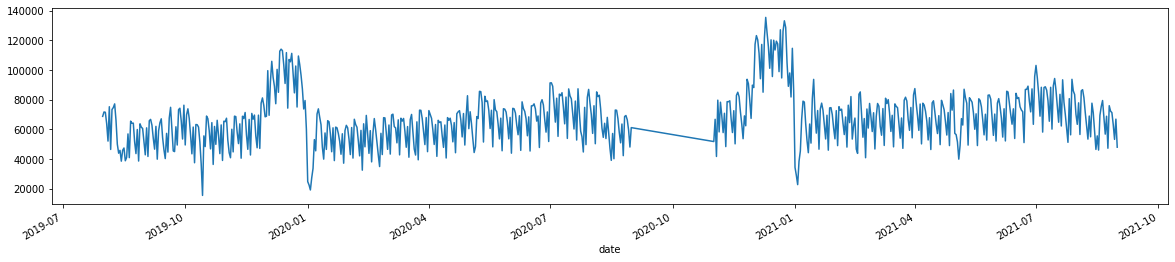

In [23]:
train_df[train_df['branch_id']==1]['delivery'].plot(figsize=(20,4))

<AxesSubplot:xlabel='date'>

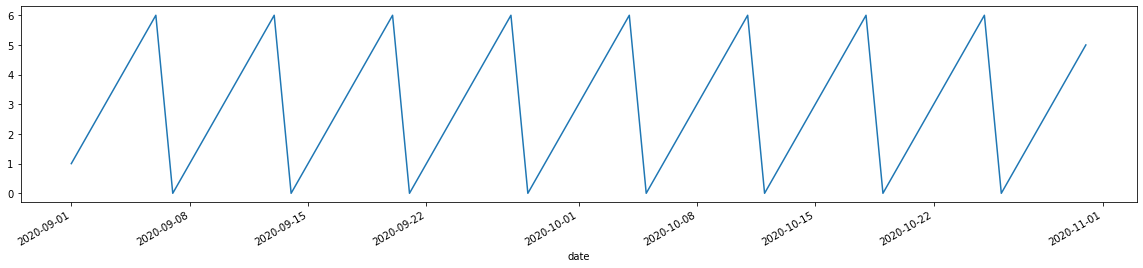

In [24]:
test_df['weekday'].plot(figsize=(20,4))

<AxesSubplot:xlabel='date'>

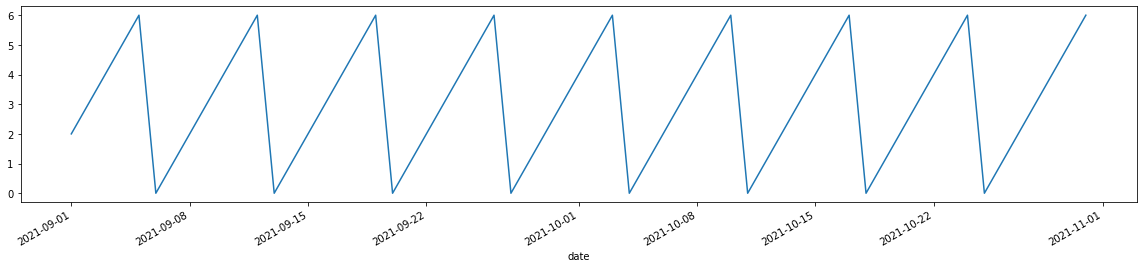

In [25]:
pred_df['weekday'].plot(figsize=(20,4))

In [26]:

best_paramas = {}
history = []

params = {'objective':'regression',
        'metric': 'rmse',
        'verbosity':-1,
        'n_jobs':-1,
        'random_state':123}

LGB = lgb2.train(params, train_data, 
                    valid_sets=[train_data, test_data],
                    verbose_eval=False,
                    )


[I 2022-02-18 00:56:23,001] A new study created in memory with name: no-name-e10c05d5-6538-4f37-8b2c-0dae40fcecc6
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/student16/.local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 6193.090596:  14%|#4        | 1/7 [00:03<00:18,  3.04s/it]/home/student16/.local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, 

In [27]:

best_params = LGB.params
print(best_params)


{'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'n_jobs': -1, 'random_state': 123, 'feature_pre_filter': False, 'lambda_l1': 2.6273052257305567, 'lambda_l2': 0.0003246664234030569, 'num_leaves': 43, 'feature_fraction': 0.5, 'bagging_fraction': 0.6467965517190535, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': None}


In [29]:
# LightGBM単体の評価
# 検証データでの精度確認(region毎に合算してdeliveryとpredictを比較)
test_df['predict'] = LGB.predict(test_x)
byregion_test_df = test_df.groupby(['date','region_id']).sum()
mape = mean_absolute_percentage_error(byregion_test_df['delivery'], byregion_test_df['predict']) * 100
print("Light GBM, MAPE =", mape)

Light GBM, MAPE = 6.028621473426504


In [30]:
# XGBoost用のデータの作成
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x, label=test_y)
dpred = xgb.DMatrix(pred_x)

/home/student16/.local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [31]:
# XGBoostの学習
params = {
    "silent": 1,
    "max_depth": 8,
    "min_child_weight": 1,
    "eta": 0.127,
    "tree_method": "exact",
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "predictor": "cpu_predictor"
}

results_dict = {}

XGB = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=1000,
                  early_stopping_rounds=5,
                  evals=[(dtrain,"train"), (dtest, "test")],
                  evals_result = results_dict) # dtestで評価を行う

[01:01:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:62640.91406	test-rmse:58896.07422
[1]	train-rmse:54860.25000	test-rmse:51976.80859
[2]	train-rmse:48071.54688	test-rmse:45998.26953
[3]	train-rmse:42146.71094	test-rmse:40167.50781
[4]	train-rmse:36997.42188	test-rmse:35652.81641
[5]	train-rmse:32510.07227	test-rmse:31480.86523
[6]	train-rmse:28610.11914	test-rmse:27853.13281
[7]	train-rmse:25220.83008	test-rmse:24768.49805
[8]	train-rmse:22277.41406	test-rmse:22182.38281
[9]	train-rmse:19719.09766	test-rmse:19503.62305
[10]	train-rmse:17514.29883	test-rmse:17358.81445
[11]	train-rmse:15608.15527	test-rmse:15339.23633
[12]	train-rmse:13970.26660	test-rmse:13643.78320
[13

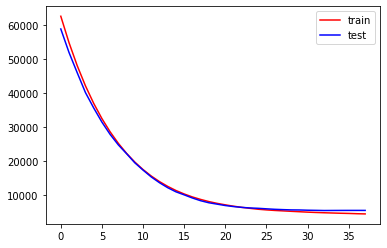

In [32]:
# XGBoostの学習曲線
plt.plot(results_dict["train"]["rmse"], color = "red", label = "train")
plt.plot(results_dict["test"]["rmse"], color = "blue", label = "test")
plt.legend()
plt.show()

In [33]:
# XGBoostの精度検証
# 検証データでの精度確認(region毎に合算してdeliveryとpredictを比較)
test_df['predict2'] = XGB.predict(dtest)
byregion_test_df = test_df.groupby(['date','region_id']).sum()
mape = mean_absolute_percentage_error(byregion_test_df['delivery'], byregion_test_df['predict2']) * 100
print("XGBoost MAPE =", mape)

XGBoost MAPE = 5.509149504939708


In [34]:
# アンサンブルの精度評価
test_df['mean_predict'] = (test_df['predict']+test_df['predict2'])/2
byregion_test_df = test_df.groupby(['date','region_id']).sum()
mape = mean_absolute_percentage_error(byregion_test_df['delivery'], byregion_test_df['mean_predict']) * 100
print("MAPE =", mape)

MAPE = 5.415860828903287


## 検証データの可視化

<AxesSubplot:xlabel='delivery', ylabel='predict'>

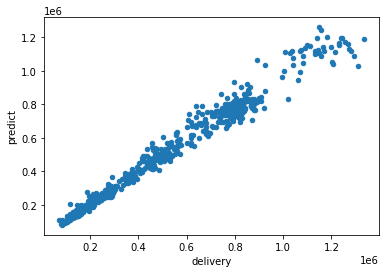

In [35]:
# LightGBMでの検証データの散布図をプロット
byregion_test_df.plot.scatter('delivery','predict')

<AxesSubplot:xlabel='delivery', ylabel='predict2'>

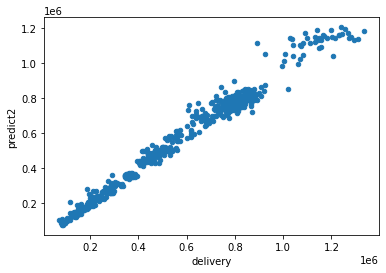

In [36]:
# XGBoostでの検証データの散布図をプロット
byregion_test_df.plot.scatter('delivery','predict2')

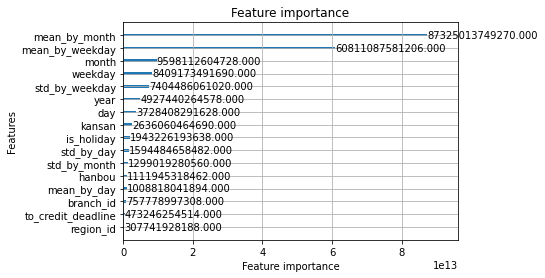

In [37]:
# LightGBMの特徴量重要度の確認
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
lgb.plot_importance(LGB, ax=ax, importance_type="gain")
plt.show()
plt.close("all")

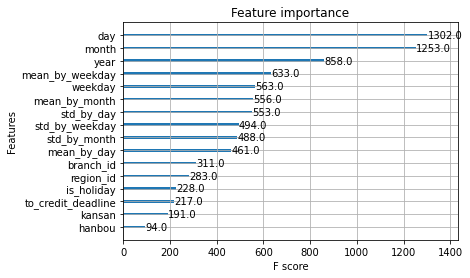

In [38]:
# XGBoostの特徴量重要度の確認
xgb.plot_importance(XGB)
plt.show()

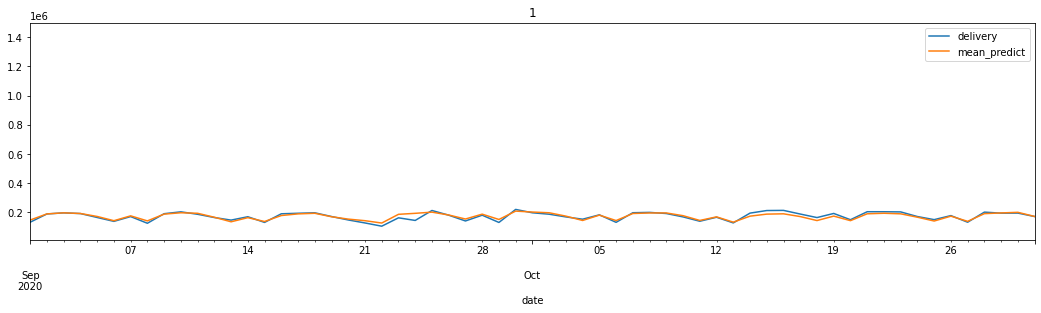

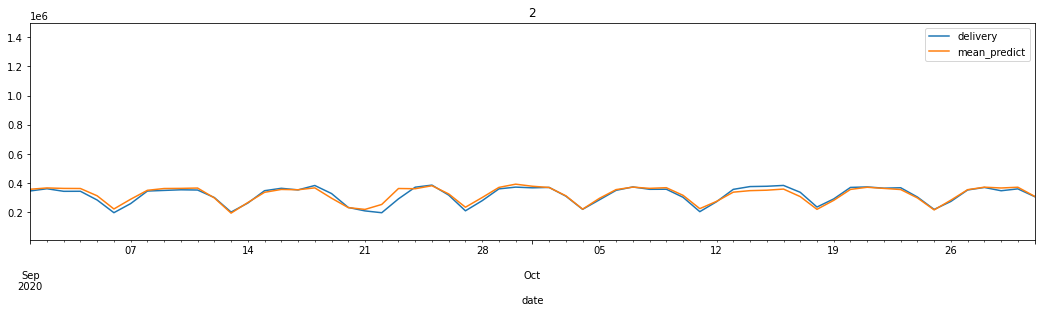

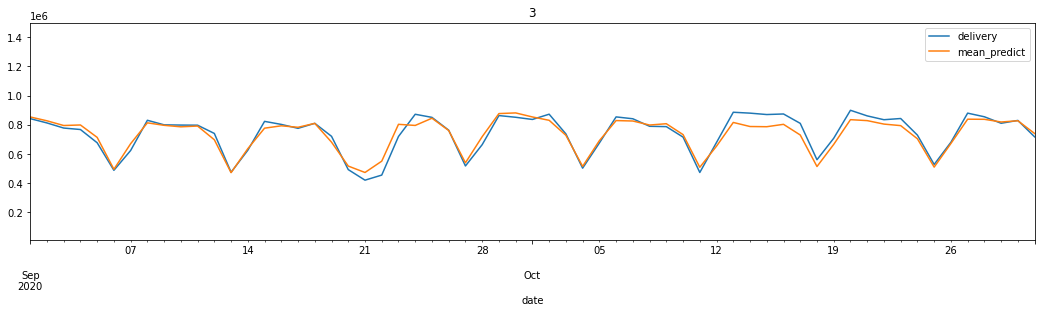

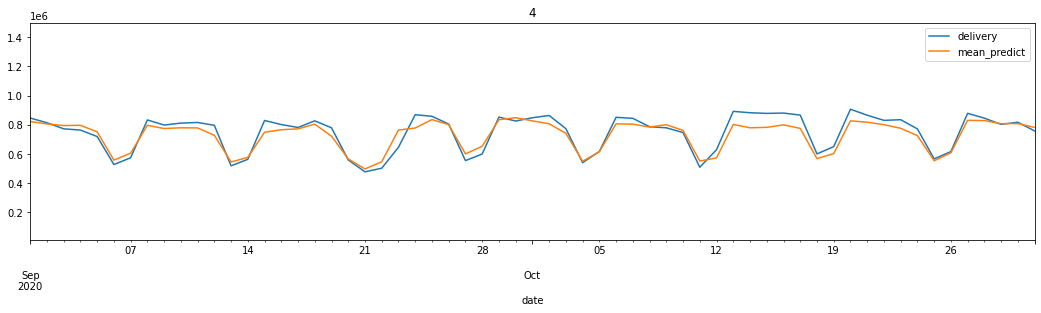

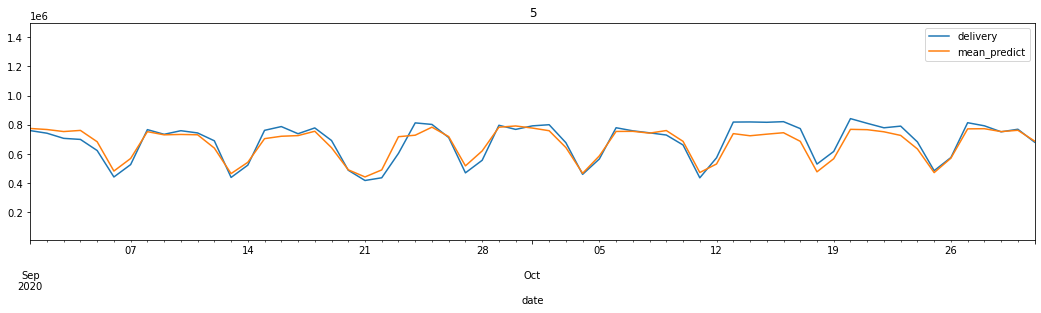

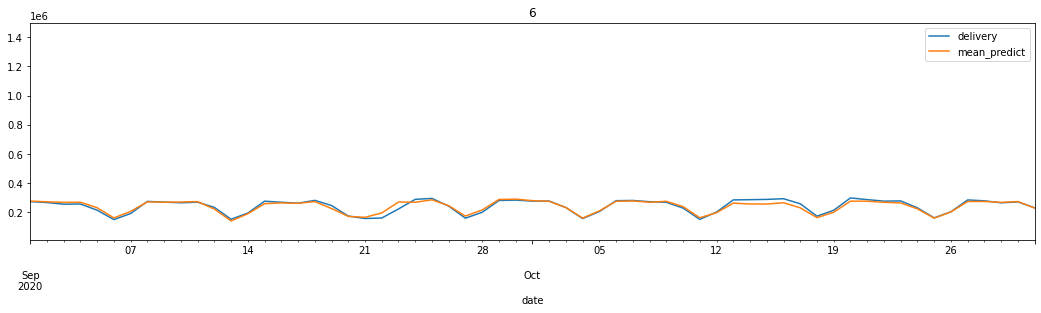

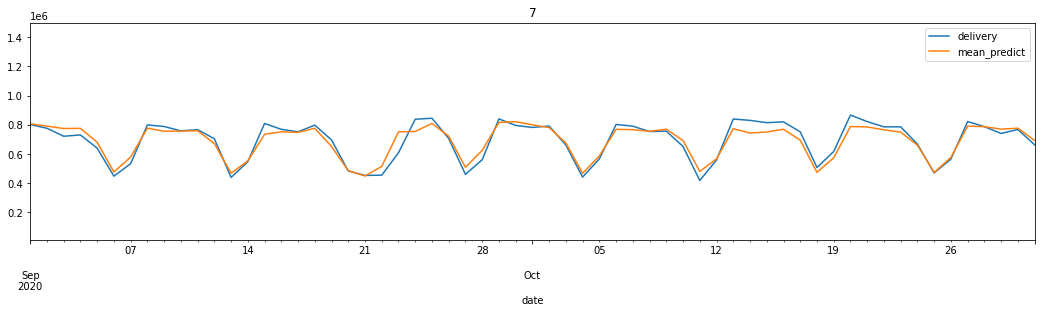

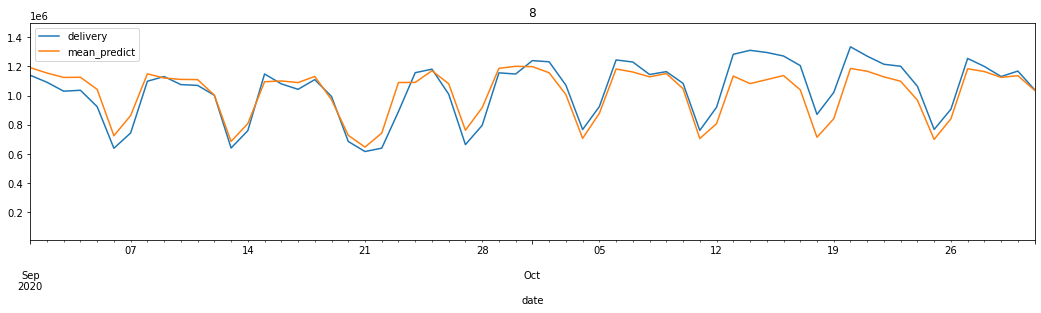

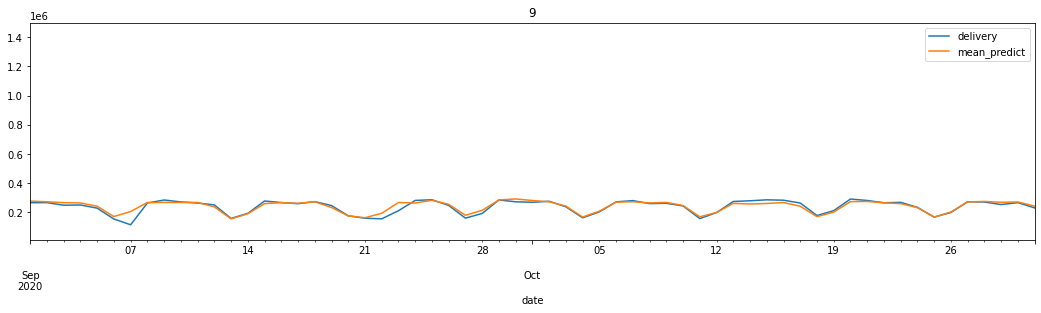

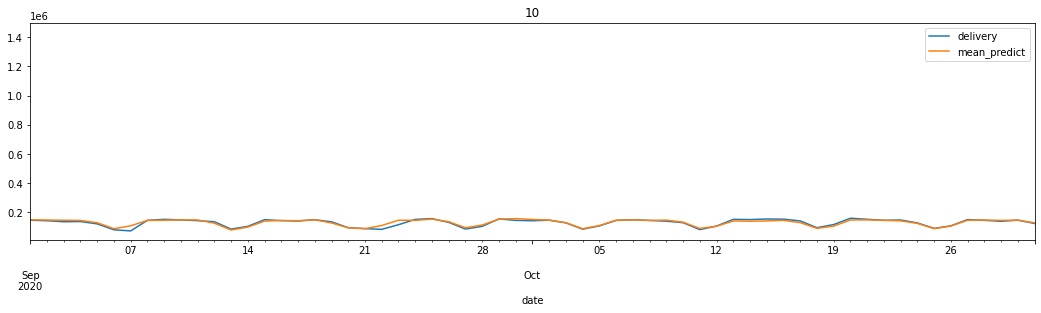

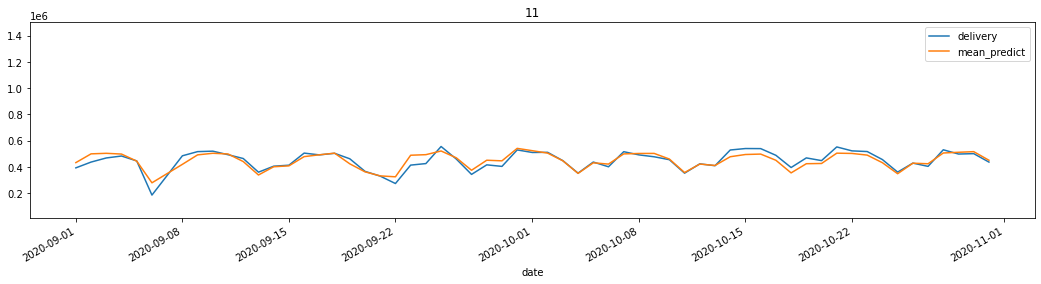

In [39]:
# region毎の予測と実際の差のプロット（予測はXGBoostとLightGBMのアンサンブル平均）
def byregion_result_plot(org_df, region):
    data = org_df[org_df['region_id']==region]
    byregion_data = data.groupby('date').sum()
    byregion_data[['delivery','mean_predict']].plot(ylim=[10000,1500000],figsize=(18,4),legend=True,title=region)

for i in range(1,12):
    byregion_result_plot(test_df,i)

## 予測

In [40]:
# 予測データでの予測
pred_df['predict'] = LGB.predict(pred_x)
pred_df['predict2'] = XGB.predict(dpred)
pred_df['mean_predict'] = (pred_df['predict']+pred_df['predict2'])/2
submission = pred_df[['region_id','mean_predict']].groupby(['date','region_id']).sum()
submission.to_csv('kakunin_teamF.csv',header=False)

In [41]:
# 行が671であることを確認
submission.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 671 entries, (Timestamp('2021-09-01 00:00:00'), 1) to (Timestamp('2021-10-31 00:00:00'), 11)
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean_predict  671 non-null    float64
dtypes: float64(1)
memory usage: 7.2 KB


array([<AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>], dtype=object)

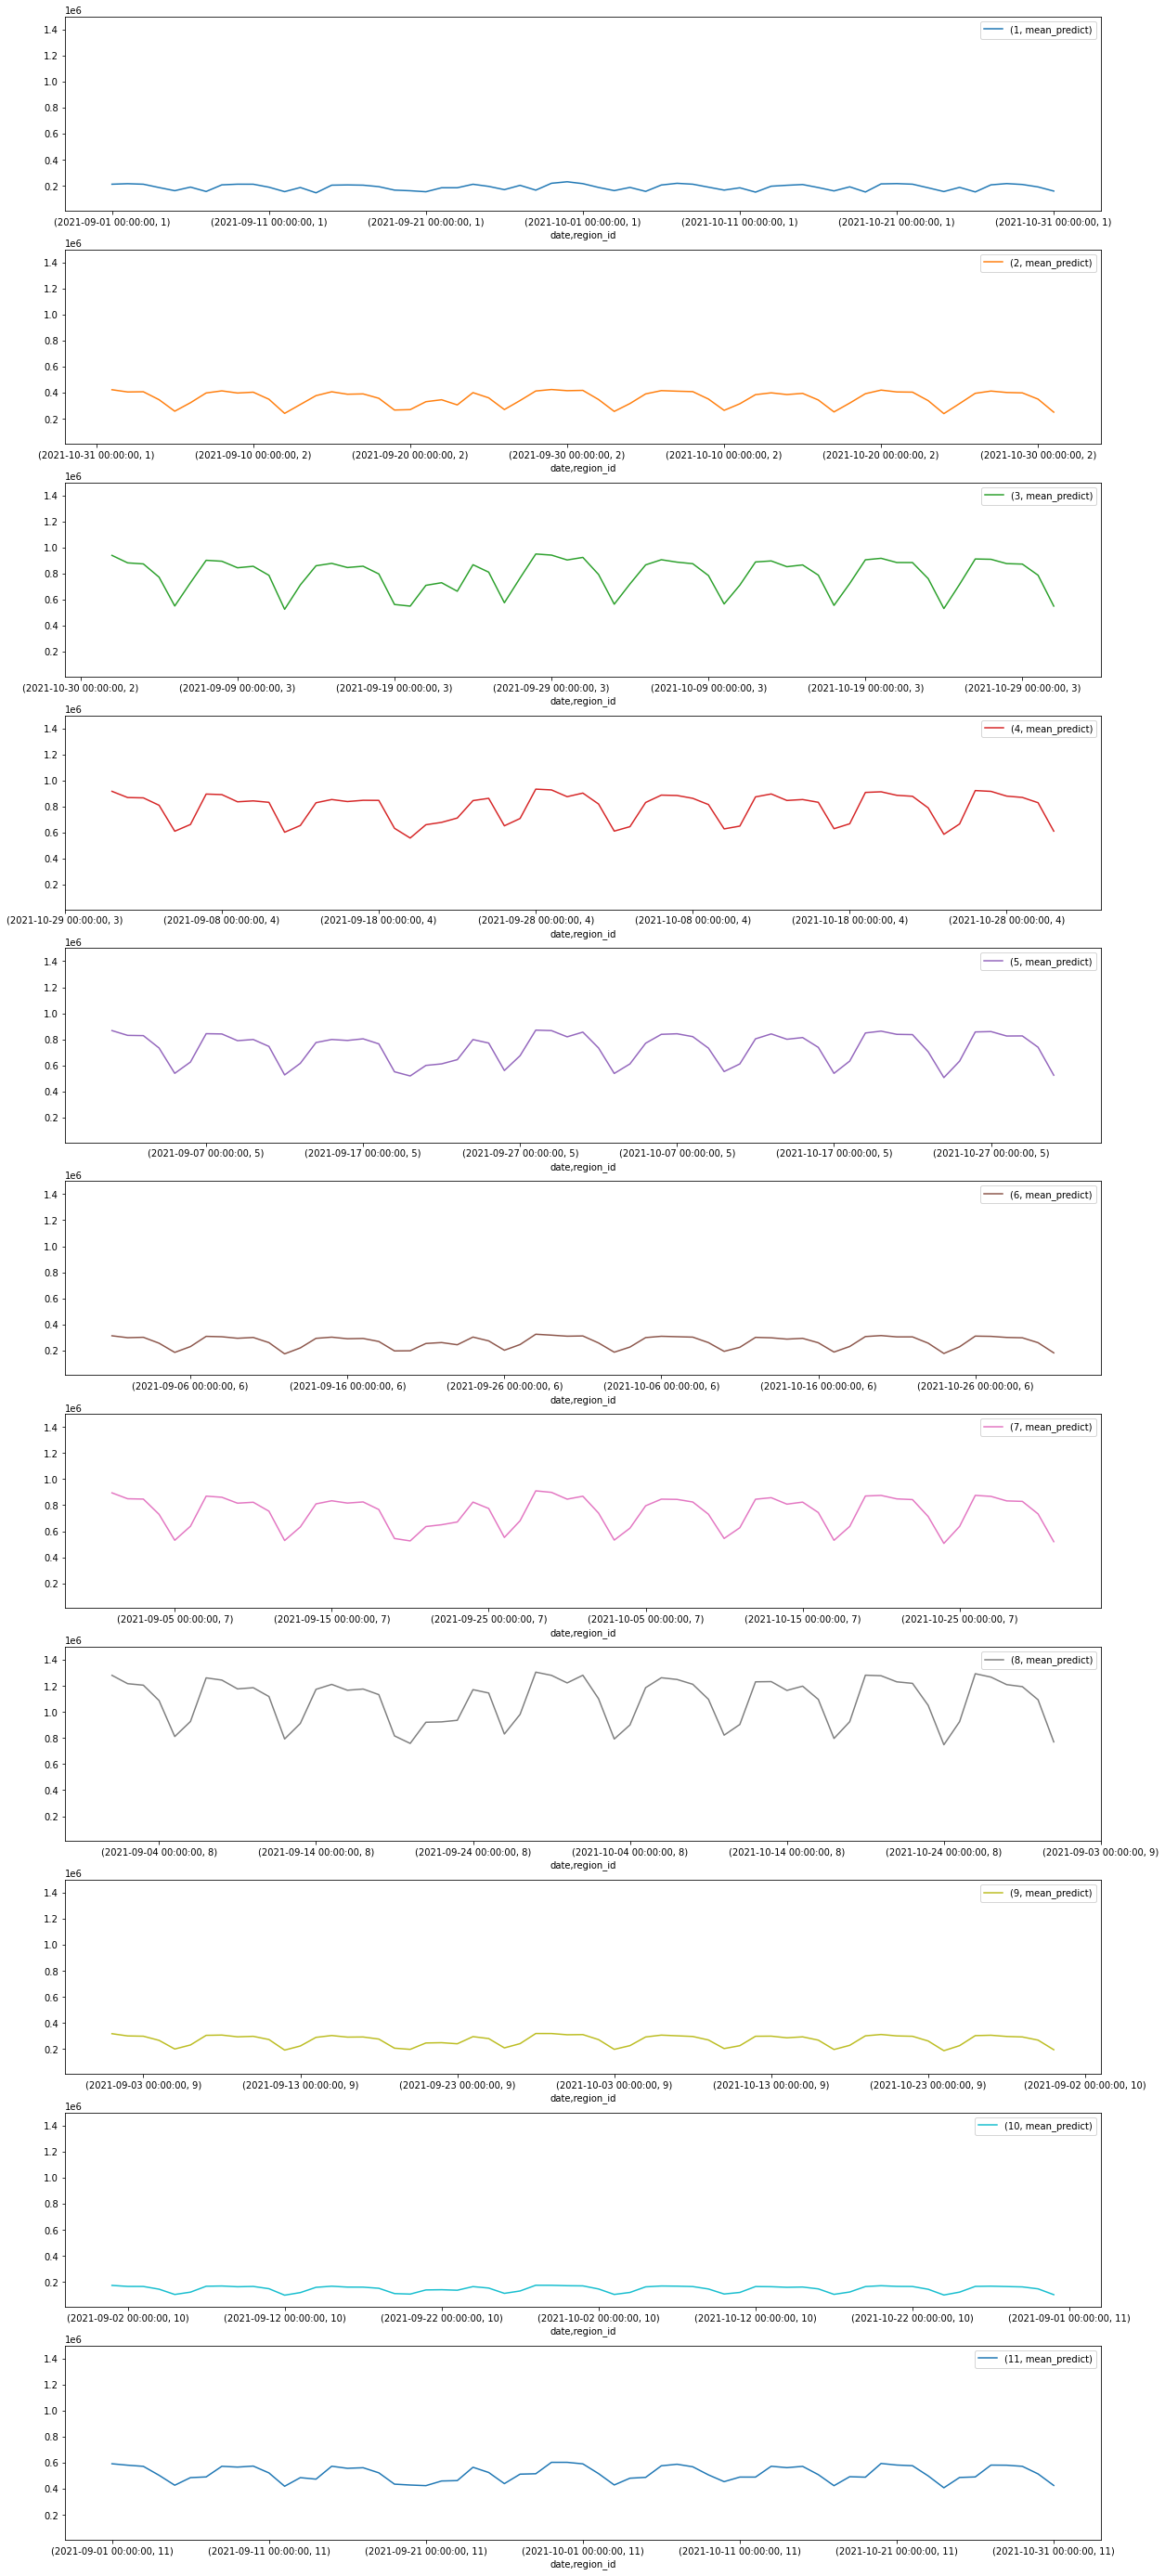

In [42]:
submission.plot(figsize=(20,50),by='region_id',ylim=[10000,1500000])

array([<AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>,
       <AxesSubplot:xlabel='date,region_id'>], dtype=object)

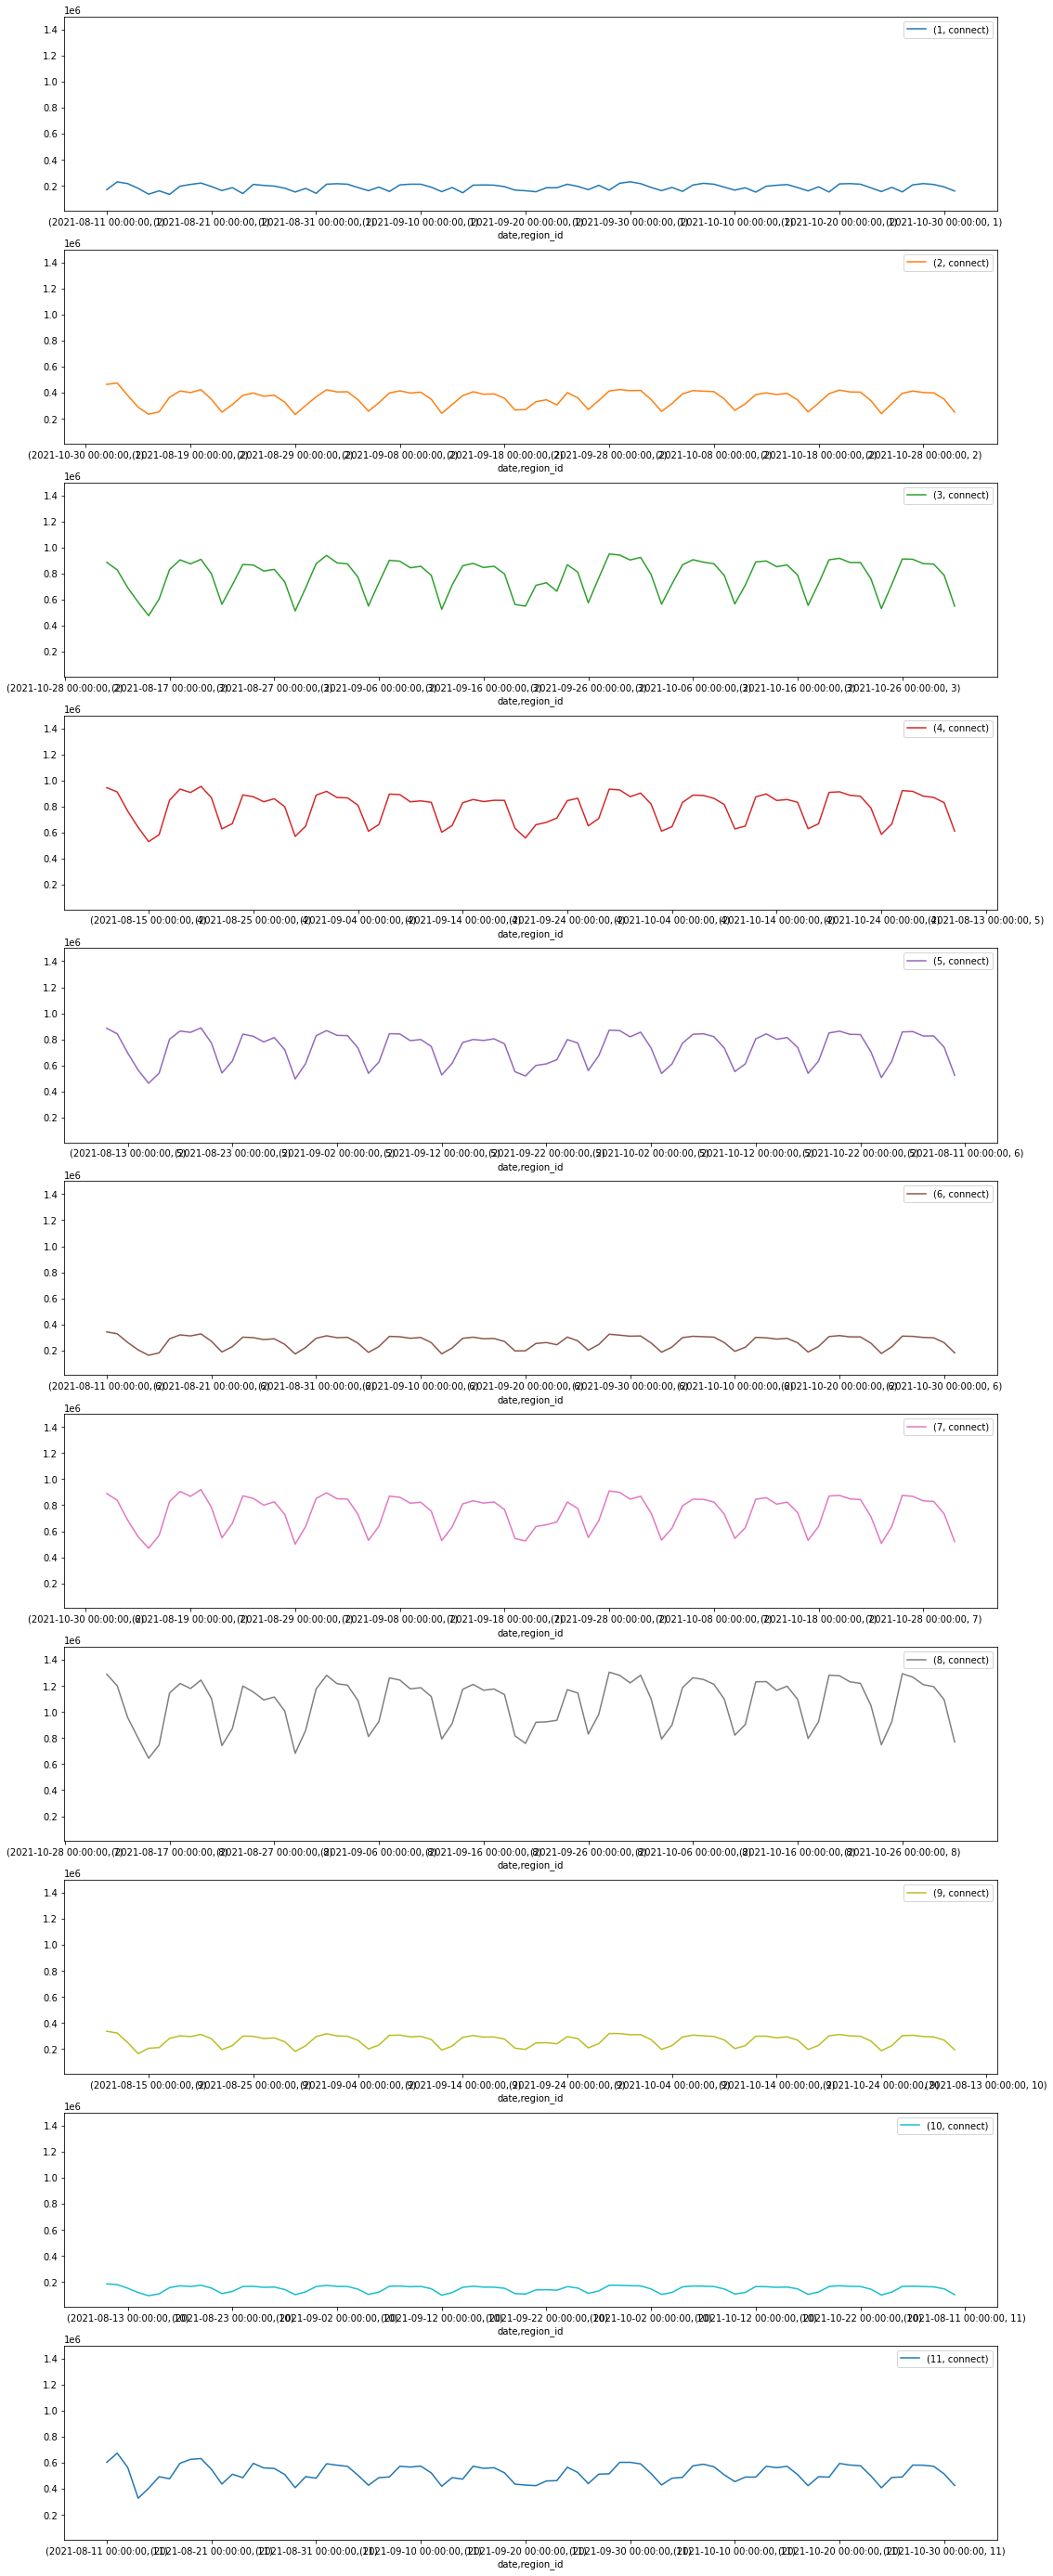

In [43]:
# 2021年8月の配達量実測値と2021年9月10月の配達量予測値を結合して地域別に表示
connect_df = df.loc[(df.index >= datetime(2021,8,11))&(df.index <= datetime(2021,8,31))].copy()
connection = connect_df[['region_id','delivery']].groupby(['date','region_id']).sum()
connection = connection.rename(columns={'delivery':'connect'})
submission = submission.rename(columns={'mean_predict':'connect'})
connected_df = pd.concat([connection,submission])
connected_df.plot(figsize=(18,50),by='region_id',ylim=[10000,1500000])